In [83]:
%matplotlib inline
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cdb_extras.xarray_support as cdbxr  # a convenient Python library for accessing the COMPASS database
from scipy.signal import savgol_filter, detrend
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AutoReg, AR

In [108]:
# Constants
N_SHOT = 17269
T_START = 1060
T_END = 1130

CHANNEL_APD = 13

DATA_DIR = './sumtraic2022/gSPRT_data/'

In [136]:
# Load the relevant signals
shot = cdbxr.Shot(N_SHOT)

_APD = shot['APD.light_profile'].sel(time=slice(T_START, T_END)).isel(R=CHANNEL_APD)
s_APD = _APD.data / np.abs(_APD.data).max()
s_APD -= savgol_filter(s_APD, 13, 9)

t_APD = _APD.time

_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END))
s_Mirnov = _Mirnov.data / np.abs(_Mirnov.data).max()
t_Mirnov = _Mirnov.time

# load ELM times
mat = scipy.io.loadmat(f'{DATA_DIR}17269_ch13.mat')
time_ELMs = mat['ELMs_time']

In [110]:
# these two time series are not defined on the same time points. We obtain this by averaging!
def time_series_average(time_arr, signal_arr, timestep=None, start=None, end=None):

    assert len(time_arr) == len(signal_arr)
    
    dt_min = max(np.diff(t_APD).max(), np.diff(t_Mirnov).max())
    if timestep is None:
        timestep = dt_min
    elif timestep < dt_min:
        timestep = dt_min
        print(f'too small timestep. Using timestep = {dt_min}')
    
    if start is None:
        start = t_APD[0]
    if end is None:
        end = t_APD[-1]

    assert len(time_arr) > (end - start) / timestep, 'too short time_step!'
   

    time = np.arange(start, end-timestep, timestep)
    
    # optimize this?
    signal_ave = np.array([signal_arr[(t<=time_arr)&(time_arr<t+timestep)].mean() for t in time])
    time += timestep / 2
    
    return time, signal_ave

In [137]:
# OBS for larger intervals, this may take up to a minute to run
at_APD, as_APD = time_series_average(t_APD, s_APD, start=T_START, end=T_END)
at_Mirnov, as_Mirnov = time_series_average(t_Mirnov, s_Mirnov, start=T_START, end=T_END)


(-1.0, 1.0)

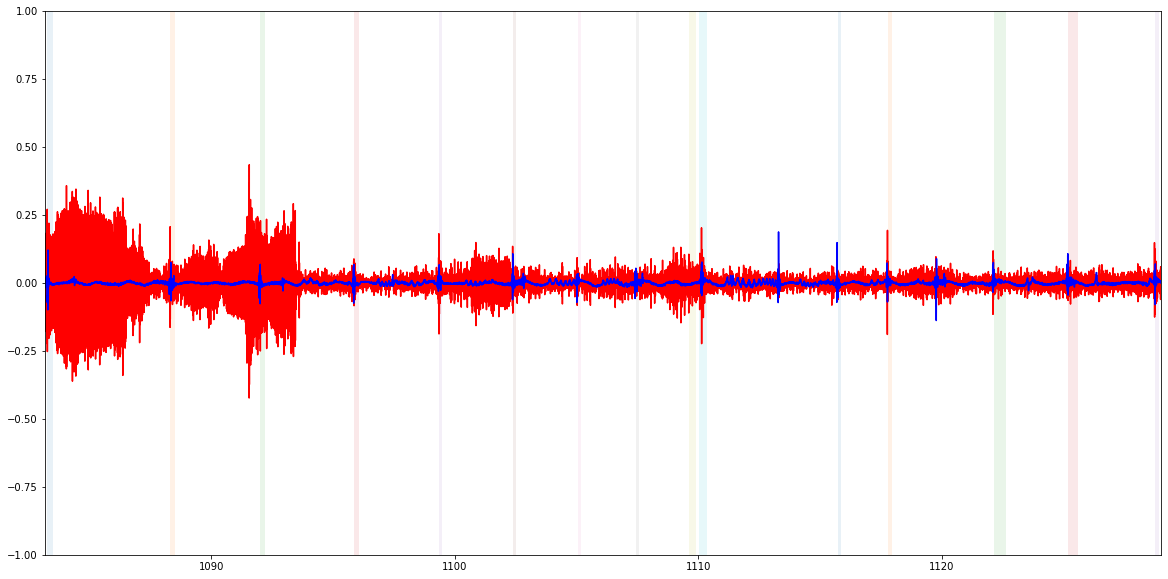

In [140]:
plt.figure(figsize=(20, 10))

plt.plot(at_APD, as_APD, 'r')
plt.plot(at_Mirnov, as_Mirnov, 'b')

for i in range(len(time_ELMs)):
    plt.fill_between(time_ELMs[i,:], -1, 1, alpha=.1)
    
plt.xlim(time_ELMs[0,0]-.1, time_ELMs[-1,1]+.1)
plt.ylim(-1, 1)


(-1.0, 1.0)

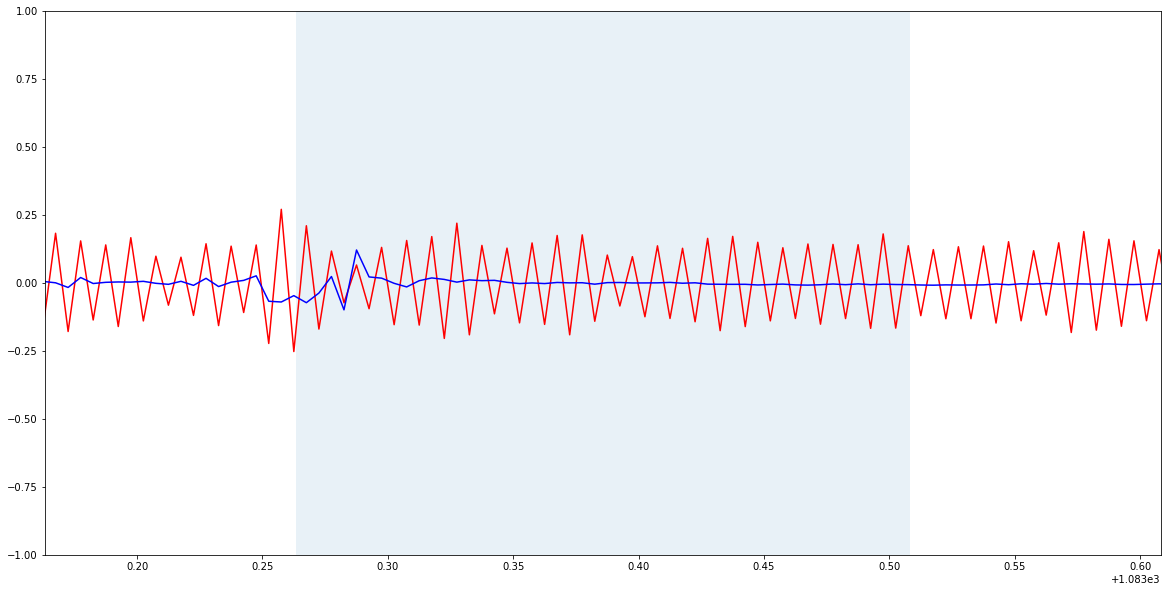

In [148]:
plt.figure(figsize=(20, 10))

plt.plot(at_APD, as_APD, 'r')
plt.plot(at_Mirnov, as_Mirnov, 'b')

i = 0
plt.fill_between(time_ELMs[i,:], -1, 1, alpha=.1)
plt.xlim(time_ELMs[i,0]-.1, time_ELMs[i,1]+.1)
plt.ylim(-1, 1)

In [149]:
# Code from previous year, sent to us by Miklós
import warnings
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR

def get_gcc(x, y, d=9):
    """Computes F value wether y Granger causes x

    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
    :return: log(F) value for y -> x
    :rtype: float

    """
    warnings.simplefilter("ignore")
    
    # for definition of AR => (https://en.wikipedia.org/wiki/Autoregressive_model#Definition)
    ar = AR(x)
    ar_fit = ar.fit(d)
    var = VAR(np.array([x, y]).T)
    var_fit = var.fit(d)
   
    #print(var_fit.summary())
    
    return np.log(ar_fit.resid.var() / var_fit.resid.var(axis=0)[0])

In [150]:
for start, end in time_ELMs:

    apd = as_APD[(start<at_APD)&(at_APD<end)]
    mirnov = as_Mirnov[(start<at_Mirnov)&(at_Mirnov<end)]
    
    print(get_gcc(apd, mirnov), get_gcc(mirnov))
    

1083.2632634542824
1088.298263693432
1091.9982638691727
1095.8632640527503
1099.3632642189914
1102.3982643631462
1105.0582644894894
1107.4282646020583
1109.6082647056028
1110.0482647265017
1115.7282649962872
1117.8132650953194
1122.1432653009833
1125.2132654468005
1128.7732656158914


## old

In [36]:
# Load the relevant signals
shot = cdbxr.Shot(N_SHOT)

x = shot['APD.light_profile'].sel(time=slice(T_START, T_END)).isel(R=CHANNEL_APD).time


y = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END)).time[:-1:10]

print(np.diff(x).max(), np.diff(x).min())

print(np.diff(y).max(), np.diff(y).min())


data=pd.DataFrame({
    'time': shot['APD.light_profile'].sel(time=slice(T_START, T_END)).time,
    'APD': shot['APD.light_profile'].sel(time=slice(T_START, T_END)).isel(R=CHANNEL_APD).data,
    'Mirnov': shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END)).data[:-1:10]
})

# High-pass filtering of APD signal -> stationary
data['APD'] -= savgol_filter(data['APD'], 11, 8)
 
# Normalize data
data['APD'] /= data['APD'].max()
data['Mirnov'] /= data['Mirnov'].max()

# visualize signals
plt.plot(data['time'], data['APD'], label='APD')
plt.plot(data['time'], data['Mirnov'], label='Mirnov')
plt.legend()
plt.show()

0.0050000002374872565 0.0050000002374872565
0.005000000000109139 0.004999999999881766


ValueError: arrays must all be same length

Minimum AIC :  -9.103431402778394 Lag order =  32


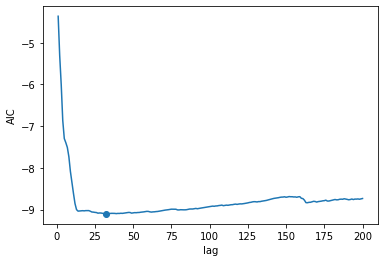

In [5]:
# obtain the optimal lag for VAR
max_lag = 200
aic = np.zeros(max_lag)

for i in range(max_lag):
    
    # auto regression
    model = AutoReg(data['APD'], i+1)
    aic[i] = model.fit().aic
    
plt.plot(np.linspace(1, max_lag, max_lag), aic)
plt.scatter(aic.argmin()+1, aic.min())
plt.ylabel('AIC')
plt.xlabel('lag')

print('Minimum AIC : ', aic.min(), 'Lag order = ', aic.argmin()+1)

In [16]:
# load ELM times
import scipy.io
mat = scipy.io.loadmat(f'{DATA_DIR}17269_ch13.mat')
time_ELMs = mat['ELMs_time']

data[(time_ELMs[2, 0]<data['time'])&(data['time']<time_ELMs[2, 1])]

,time,APD,Mirnov


In [190]:
%pwd

'/compass/home/halldestam'

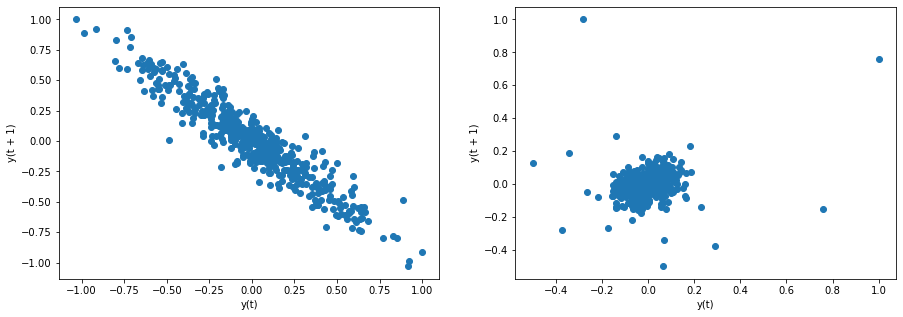

In [184]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

pd.plotting.lag_plot(data['APD'], ax=ax1)
pd.plotting.lag_plot(data['Mirnov'], ax=ax2)
plt.show()

In [185]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

x_APD = np.array(data['APD'])
x_Mirnov = np.array(data['Mirnov'])

kpss_test(x_APD[~np.isnan(x_APD)])
kpss_test(x_Mirnov[~np.isnan(x_Mirnov)])

KPSS Statistic: 0.019561035126615882
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.7225120571737983
p-value: 0.011498903893291064
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


In [119]:
# copy data
rawData = data.copy(deep=True)

# take 1 first difference
data['APD'] = data['APD'] - data['APD'].shift(1)
data['Mirnov'] = data['Mirnov'] - data['Mirnov'].shift(1)
data = data.dropna()

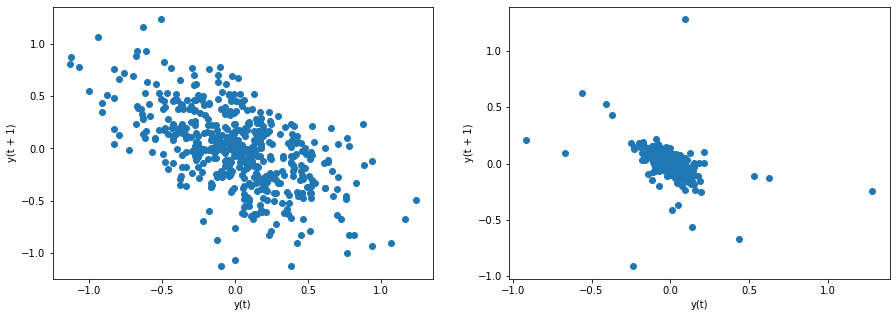

KPSS Statistic: 0.020667735693248066
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.02267378336890677
p-value: 0.1
num lags: 18
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

pd.plotting.lag_plot(data['APD'], ax=ax1)
pd.plotting.lag_plot(data['Mirnov'], ax=ax2)
plt.show()

x_APD = np.array(data['APD'])
x_Mirnov = np.array(data['Mirnov'])

kpss_test(x_APD[~np.isnan(x_APD)])
kpss_test(x_Mirnov[~np.isnan(x_Mirnov)])

In [150]:
# obtain the lag P for VAR
rawData = rawData.dropna()
model = AutoReg(rawData) #recall that rawData is w/o difference operation

_min, _i = np.inf, 0
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    try:
        if result.aic < _min:
            _min = result.aic
            _i = i
        
        print('Lag Order =', i)
        print('AIC : ', result.aic, '\n')
        
    except:
        continue

print('Minimum AIC : ', _min, 'Lag order = ', _i)

NameError: name 'AutoReg' is not defined

In [122]:
# split data into train and test for the VAR analysis
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

model = VAR(train)
model_fitted = model.fit(9)

In [123]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

time : 1.96
APD : 2.0
Mirnov : 2.0


In [127]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(train, variables=train.columns, verbose=True)

Y = time, X = time, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = APD, X = time, P Values = [0.3851, 0.2724, 0.3547, 0.4287, 0.2553, 0.2738, 0.216, 0.1128]
Y = Mirnov, X = time, P Values = [0.986, 0.1973, 0.1468, 0.2153, 0.3245, 0.5498, 0.5863, 0.5666]
Y = time, X = APD, P Values = [0.3024, 0.411, 0.3685, 0.4897, 0.5805, 0.3744, 0.4017, 0.4882]
Y = APD, X = APD, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = Mirnov, X = APD, P Values = [0.1708, 0.2692, 0.2674, 0.0356, 0.0551, 0.0769, 0.0621, 0.0622]
Y = time, X = Mirnov, P Values = [0.1193, 0.2518, 0.0035, 0.0043, 0.0086, 0.0017, 0.0015, 0.0028]
Y = APD, X = Mirnov, P Values = [0.3869, 0.1633, 0.0884, 0.0437, 0.065, 0.0004, 0.0011, 0.0023]
Y = Mirnov, X = Mirnov, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


,time_x,APD_x,Mirnov_x
time_y,1.0000,0.3024,0.0015
APD_y,0.1128,1.0000,0.0004
Mirnov_y,0.1468,0.0356,1.0000


In [125]:
# Code from previous year, sent to us by Miklós
import warnings
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR

def get_gcc(x, y, d=9):
    """Computes F value wether y Granger causes x

    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
    :return: log(F) value for y -> x
    :rtype: float

    """
    warnings.simplefilter("ignore")
    
    # for definition of AR => (https://en.wikipedia.org/wiki/Autoregressive_model#Definition)
    ar = AR(x)
    ar_fit = ar.fit(d)
    var = VAR(np.array([x, y]).T)
    var_fit = var.fit(d)
   
    #print(var_fit.summary())
    
    return np.log(ar_fit.resid.var() / var_fit.resid.var(axis=0)[0])

In [60]:
data['time'][100]

1087.5032636556716

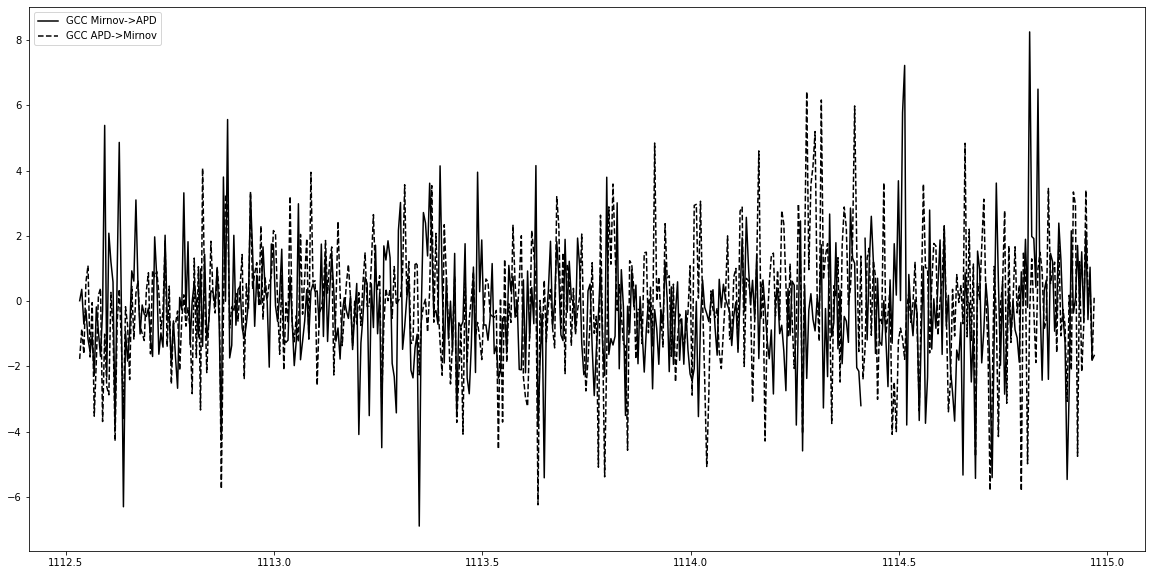

In [139]:
WINDOW = 13

t_gcc = np.zeros(data['time'].size - WINDOW + 1)
sxy_gcc = np.zeros(t_gcc.shape)
syx_gcc = np.zeros(t_gcc.shape)

for i, _ in enumerate(t_gcc):
    t_gcc[i] = data['time'][i+int((WINDOW-1)/2)]
    
    x = np.array(data['APD'][i:i+WINDOW])
    y = np.array(data['Mirnov'][i:i+WINDOW])

    sxy_gcc[i] = get_gcc(x, y)
    syx_gcc[i] = get_gcc(y, x)

plt.figure(figsize=(20, 10))
plt.plot(t_gcc, sxy_gcc, c='k', label='GCC Mirnov->APD')
plt.plot(t_gcc, syx_gcc, 'k--', label='GCC APD->Mirnov')
#plt.plot(t_APD, s_APD, c='r', alpha=.6, label='APD')
#plt.plot(t_Mirnov, s_Mirnov, c='b', alpha=.6, label='Mirnov')
plt.legend()